In [17]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import numpy as np
import shapely.geometry
import shapely
from shapely import wkt
import rasterio
import rioxarray
from rasterio.features import shapes
from shapely.geometry import shape
import matplotlib.pyplot as plt
from pathlib import Path
import shapely.plotting
from shapely.geometry import Polygon

import shapely.wkt
import shapely.geometry

In [18]:
existingplants = pd.read_csv("Data\\ExistingPlants_wPosition.csv")
existingplants = gpd.GeoDataFrame(existingplants, geometry =gpd.points_from_xy(existingplants['longitude'],existingplants['latitude']))
existingplants.crs = {'init': 'epsg:4326'}
# existingplants = existingplants.loc[existingplants['EXP_MW'] >= 1]
existingplants.reset_index(inplace=True,drop=True)
        
for i in existingplants.columns:
    if i not in ['Sale_MW','FuelTypeName','latitude','longitude','geometry']:
        existingplants = existingplants.drop(columns=i)

existingplants['area'] = existingplants['geometry'].buffer(0.025)
print(existingplants.columns)

Index(['FuelTypeName', 'Sale_MW', 'latitude', 'longitude', 'geometry', 'area'], dtype='object')


C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Local\Temp\ipykernel_9540\2937365373.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  existingplants['area'] = existingplants['geometry'].buffer(0.025)


In [19]:

REbiglot = pd.read_excel('Data\\NewVRE.xlsx',sheet_name='สรุปผู้ที่ได้รับการคัดเลือก')
REbiglot = gpd.GeoDataFrame(REbiglot, geometry =gpd.points_from_xy(REbiglot['lon'],REbiglot['lat']))
REbiglot.crs = {'init': 'epsg:4326'}
REbiglot.reset_index(inplace=True,drop=True)

REbiglot['area'] = REbiglot['geometry'].buffer(0.025)
print(existingplants.columns)

Index(['FuelTypeName', 'Sale_MW', 'latitude', 'longitude', 'geometry', 'area'], dtype='object')


C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Local\Temp\ipykernel_9540\1785764699.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  REbiglot['area'] = REbiglot['geometry'].buffer(0.025)


In [20]:
xr_final_SI = xr.open_dataset('Output\\xr_final_SI.nc')
df_final_SI = xr_final_SI.to_dataframe()
df_final_SI.reset_index(inplace=True)
df_final_SI = gpd.GeoDataFrame(df_final_SI, geometry =gpd.points_from_xy(df_final_SI['lon'],df_final_SI['lat']))
df_final_SI.crs = {'init': 'epsg:4326'}
df_final_SI['aux'] = 1
print(df_final_SI)

               lat         lon  SI_Solar  SI_Wind  AVA_Wind  AVA_Solar  \
0         5.618056   97.348611       0.0      0.0       0.0        0.0   
1         5.618056   97.356944       0.0      0.0       0.0        0.0   
2         5.618056   97.365278       0.0      0.0       0.0        0.0   
3         5.618056   97.373611       0.0      0.0       0.0        0.0   
4         5.618056   97.381944       0.0      0.0       0.0        0.0   
...            ...         ...       ...      ...       ...        ...   
1773085  20.459722  105.598611       0.0      0.0       0.0        0.0   
1773086  20.459722  105.606944       0.0      0.0       0.0        0.0   
1773087  20.459722  105.615278       0.0      0.0       0.0        0.0   
1773088  20.459722  105.623611       0.0      0.0       0.0        0.0   
1773089  20.459722  105.631944       0.0      0.0       0.0        0.0   

                           geometry  aux  
0          POINT (97.34861 5.61806)    1  
1          POINT (97.3569

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [21]:
for i in range(len(existingplants)) :
    df_final_SI['aux'].loc[(df_final_SI['aux'] == 1) & (df_final_SI.within(existingplants['area'][i]))] = 0

for i in range(len(REbiglot)) :
    df_final_SI['aux'].loc[(df_final_SI['aux'] == 1) & (df_final_SI.within(REbiglot['area'][i]))] = 0

df_final_SI['SI_Wind'] = df_final_SI['SI_Wind'] * df_final_SI['aux']
df_final_SI['SI_Solar'] = df_final_SI['SI_Solar'] * df_final_SI['aux']
df_final_SI['AVA_Wind'] = df_final_SI['AVA_Wind'] * df_final_SI['aux']
df_final_SI['AVA_Solar'] = df_final_SI['AVA_Solar'] * df_final_SI['aux']

df_final_SI = df_final_SI.drop(columns=['aux','geometry'])
df_final_SI = df_final_SI.set_index(['lat', 'lon'])
xr_final_SI = xr.Dataset.from_dataframe(df_final_SI)

C:\Users\basna\AppData\Local\Temp\ipykernel_9540\555188084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_SI['aux'].loc[(df_final_SI['aux'] == 1) & (df_final_SI.within(existingplants['area'][i]))] = 0
C:\Users\basna\AppData\Local\Temp\ipykernel_9540\555188084.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final_SI['aux'].loc[(df_final_SI['aux'] == 1) & (df_final_SI.within(REbiglot['area'][i]))] = 0


In [22]:
xr_final_SI.to_netcdf(path='Output\\xr_final_SI_exc.nc')

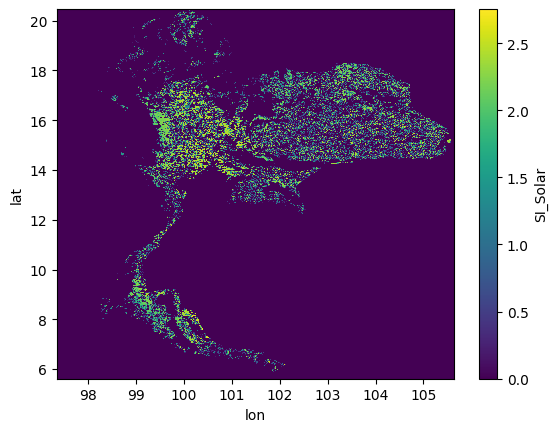

In [23]:
xr_final_SI['SI_Solar'].plot()

In [24]:
print("AVA Wind = ",xr_final_SI['AVA_Wind'].sum())
print("AVA Solar = ",xr_final_SI['AVA_Solar'].sum())

AVA Wind =  <xarray.DataArray 'AVA_Wind' ()>
array(81770.67, dtype=float32)
AVA Solar =  <xarray.DataArray 'AVA_Solar' ()>
array(89610.04, dtype=float32)


## I assign the region to each grid ## 

In [25]:
region = pd.read_csv('Data\\Region.csv',index_col=False)
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')

thailandmap.crs = {'init': 'epsg:4326'}
list_region = []

count = 0
for i in thailandmap['ADM1_TH']:
    r = region['region'].loc[region['province'] == i]
    try : 
        # print(i,r.values[0])
        list_region.append(r.values[0])
    except :
        print(i,'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
        list_region.append('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')       
    
thailandmap['region'] = list_region
thailandmap['center'] = thailandmap['geometry'].centroid
thailandmap = thailandmap.set_geometry('center')
thailandmap = thailandmap.drop(columns = 'geometry')
print(thailandmap)

    Shape_Leng  Shape_Area                   ADM1_EN          ADM1_TH  \
0     2.417227    0.131339                   Bangkok    กรุงเทพมหานคร   
1     1.695100    0.079262              Samut Prakan      สมุทรปราการ   
2     1.251111    0.053238                Nonthaburi          นนทบุรี   
3     1.884945    0.126983              Pathum Thani         ปทุมธานี   
4     3.041716    0.213938  Phra Nakhon Si Ayutthaya  พระนครศรีอยุธยา   
..         ...         ...                       ...              ...   
72    5.192570    0.385879                     Trang             ตรัง   
73    3.257829    0.316268               Phatthalung           พัทลุง   
74    2.820830    0.160825                   Pattani          ปัตตานี   
75    4.839230    0.365448                      Yala             ยะลา   
76    3.456840    0.366648                Narathiwat         นราธิวาส   

   ADM1_PCODE  ADM1_REF  ADM1ALT1EN  ADM1ALT2EN  ADM1ALT1TH  ADM1ALT2TH  \
0        TH10       NaN         NaN         NaN 

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\basna\AppData\Local\Temp\ipykernel_9540\4153731743.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  thailandmap['center'] = thailandmap['geometry'].centroid


In [26]:
xr_final_SI = xr.open_dataset('Output\\xr_final_SI_exc.nc')
df_final_SI = xr_final_SI.to_dataframe()
df_final_SI.reset_index(inplace=True)
df_final_SI = gpd.GeoDataFrame(df_final_SI, geometry =gpd.points_from_xy(df_final_SI['lon'],df_final_SI['lat']))
df_final_SI.crs = {'init': 'epsg:4326'}

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [27]:
df_final_SI_2 = gpd.sjoin_nearest(df_final_SI,thailandmap,how='left')

C:\Users\basna\AppData\Roaming\Python\Python311\site-packages\geopandas\array.py:364: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [28]:
print(df_final_SI_2.columns)

print(len(df_final_SI))
print(len(df_final_SI_2))

Index(['lat', 'lon', 'SI_Solar', 'SI_Wind', 'AVA_Wind', 'AVA_Solar',
       'geometry', 'index_right', 'Shape_Leng', 'Shape_Area', 'ADM1_EN',
       'ADM1_TH', 'ADM1_PCODE', 'ADM1_REF', 'ADM1ALT1EN', 'ADM1ALT2EN',
       'ADM1ALT1TH', 'ADM1ALT2TH', 'ADM0_EN', 'ADM0_TH', 'ADM0_PCODE', 'date',
       'validOn', 'validTo', 'region'],
      dtype='object')
1773090
1773090


In [29]:
df_final_SI_2 = df_final_SI_2.drop(columns=
                                                         ['index_right'
                                                          ,'Shape_Leng'
                                                          ,'Shape_Area'
                                                          ,'ADM1_PCODE'
                                                          ,'ADM1_REF'
                                                          ,'ADM1ALT1EN'
                                                          ,'ADM1ALT2EN'
                                                          ,'ADM1ALT1TH'
                                                          ,'ADM1ALT2TH'
                                                          ,'ADM0_EN'
                                                          ,'ADM0_TH'
                                                          ,'ADM0_PCODE'
                                                          ,'date'
                                                          ,'validOn'
                                                          ,'validTo'
                                                          ])
print(df_final_SI_2.columns)

Index(['lat', 'lon', 'SI_Solar', 'SI_Wind', 'AVA_Wind', 'AVA_Solar',
       'geometry', 'ADM1_EN', 'ADM1_TH', 'region'],
      dtype='object')


In [30]:
print(df_final_SI_2)

               lat         lon  SI_Solar  SI_Wind  AVA_Wind  AVA_Solar  \
0         5.618056   97.348611       0.0      0.0       0.0        0.0   
1         5.618056   97.356944       0.0      0.0       0.0        0.0   
2         5.618056   97.365278       0.0      0.0       0.0        0.0   
3         5.618056   97.373611       0.0      0.0       0.0        0.0   
4         5.618056   97.381944       0.0      0.0       0.0        0.0   
...            ...         ...       ...      ...       ...        ...   
1773085  20.459722  105.598611       0.0      0.0       0.0        0.0   
1773086  20.459722  105.606944       0.0      0.0       0.0        0.0   
1773087  20.459722  105.615278       0.0      0.0       0.0        0.0   
1773088  20.459722  105.623611       0.0      0.0       0.0        0.0   
1773089  20.459722  105.631944       0.0      0.0       0.0        0.0   

                           geometry    ADM1_EN ADM1_TH region  
0          POINT (97.34861 5.61806)     Phuket 

In [31]:
df_final_SI_2 = df_final_SI_2.drop(columns=['geometry'])
df_final_SI_2 = df_final_SI_2.drop(columns=['ADM1_TH'])
df_final_SI_2 = df_final_SI_2.set_index(['lat', 'lon'])
xr_final_SI = xr.Dataset.from_dataframe(df_final_SI_2)
xr_final_SI.to_netcdf(path='Output\\xr_final_SI_exc_r.nc')

In [32]:
print(xr_final_SI)

<xarray.Dataset>
Dimensions:    (lat: 1782, lon: 995)
Coordinates:
  * lat        (lat) float64 5.618 5.626 5.635 5.643 ... 20.43 20.44 20.45 20.46
  * lon        (lon) float64 97.35 97.36 97.37 97.37 ... 105.6 105.6 105.6 105.6
Data variables:
    SI_Solar   (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SI_Wind    (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Wind   (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AVA_Solar  (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ADM1_EN    (lat, lon) object 'Phuket' 'Phuket' ... 'Bueng Kan' 'Bueng Kan'
    region     (lat, lon) object 'R3' 'R3' 'R3' 'R3' ... 'R2' 'R2' 'R2' 'R2'
